In [5]:
# First cell: Updated imports
from __future__ import absolute_import, division, print_function

import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans
import tensorflow as tf
import cv2
from keras import *
from keras import backend as K
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.preprocessing.image import *
from keras.losses import *
from scipy import signal
from math import log2, log10
from scipy.ndimage import generic_laplace, uniform_filter, correlate, gaussian_filter
from scipy.ndimage.filters import uniform_filter, gaussian_filter
import warnings
from enum import Enum
from PIL import Image
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress warnings
tf.get_logger().setLevel('ERROR')

C:\Users\Admin\AppData\Local\Temp\ipykernel_6668\3729077961.py:22: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter, gaussian_filter
C:\Users\Admin\AppData\Local\Temp\ipykernel_6668\3729077961.py:22: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter, gaussian_filter


In [6]:
# Second cell: Update paths
## PATHS AND EXPERIMENT INFO ##
test_data_image_folder = 'lol_dataset/test/high'
test_data_mask_folder = 'lol_dataset/test/low'

# Update model folder path
model_folder = 'model'  # Match with training path
model_name = 'model_clienet_best.h5'
save_path = 'clienet/predictions'

IMG_HEIGHT = 256
IMG_WIDTH = 256

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [7]:
# Third cell: GPU memory growth
# Add GPU memory growth configuration (like in training notebook)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

GPU memory growth enabled


In [ ]:
# Fourth cell: Metrics definitions (mostly compatible)
## METRICS DEFINITIONS ##

def euclidean_distance_loss_nosqrt(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_pred - y_true))

class Filter(Enum):
    UNIFORM = 0
    GAUSSIAN = 1

def _get_sums(GT, P, win, mode='same'):
    mu1, mu2 = (filter2(GT, win, mode), filter2(P, win, mode))
    return mu1*mu1, mu2*mu2, mu1*mu2

def _get_sigmas(GT, P, win, mode='same', **kwargs):
    if 'sums' in kwargs:
        GT_sum_sq, P_sum_sq, GT_P_sum_mul = kwargs['sums']
    else:
        GT_sum_sq, P_sum_sq, GT_P_sum_mul = _get_sums(GT, P, win, mode)

    return filter2(GT*GT, win, mode) - GT_sum_sq,\
        filter2(P*P, win, mode) - P_sum_sq, \
        filter2(GT*P, win, mode) - GT_P_sum_mul

def fspecial(fltr, ws, **kwargs):
    if fltr == Filter.UNIFORM:
        return np.ones((ws, ws))/ ws**2
    elif fltr == Filter.GAUSSIAN:
        x, y = np.mgrid[-ws//2 + 1:ws//2 + 1, -ws//2 + 1:ws//2 + 1]
        g = np.exp(-((x**2 + y**2)/(2.0*kwargs['sigma']**2)))
        g[g < np.finfo(g.dtype).eps*g.max()] = 0
        assert g.shape == (ws,ws)
        den = g.sum()
        if den != 0:
            g /= den
        return g
    return None

def filter2(img, fltr, mode='same'):
    return signal.convolve2d(img, np.rot90(fltr, 2), mode=mode)

def _vifp_single(GT, P, sigma_nsq):
    EPS = 1e-10
    num = 0.0
    den = 0.0
    for scale in range(1, 5):
        N = 2.0**(4-scale+1)+1
        win = fspecial(Filter.GAUSSIAN, ws=int(N), sigma=N/5)

        if scale > 1:
            GT = filter2(GT, win, 'valid')[::2, ::2]
            P = filter2(P, win, 'valid')[::2, ::2]

        GT_sum_sq, P_sum_sq, GT_P_sum_mul = _get_sums(GT, P, win, mode='valid')
        sigmaGT_sq, sigmaP_sq, sigmaGT_P = _get_sigmas(GT, P, win, mode='valid', sums=(GT_sum_sq, P_sum_sq, GT_P_sum_mul))

        sigmaGT_sq[sigmaGT_sq < 0] = 0
        sigmaP_sq[sigmaP_sq < 0] = 0

        g = sigmaGT_P/(sigmaGT_sq+EPS)
        sv_sq = sigmaP_sq-g*sigmaGT_P
        
        g[sigmaGT_sq < EPS] = 0
        sv_sq[sigmaGT_sq < EPS] = sigmaP_sq[sigmaGT_sq < EPS]
        sigmaGT_sq[sigmaGT_sq < EPS] = 0
        
        g[sigmaP_sq < EPS] = 0
        sv_sq[sigmaP_sq < EPS] = 0
        
        sv_sq[g < 0] = sigmaP_sq[g < 0]
        g[g < 0] = 0
        sv_sq[sv_sq <= EPS] = EPS
        
        num += np.sum(np.log10(1.0+(g**2.)*sigmaGT_sq/(sv_sq+sigma_nsq)))
        den += np.sum(np.log10(1.0+sigmaGT_sq/sigma_nsq))

    return num/den

# VISUAL INDEX FIDELITY
def vifp(GT, P, sigma_nsq=2):
    return np.mean([_vifp_single(GT[:,:,i], P[:,:,i], sigma_nsq) for i in range(GT.shape[2])])

# PEAK SIGNAL TO NOISE RATIO
def psnr(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
# ABSOLUTE BRIGHTNESS
def ab(y_true, y_pred):
    return np.abs(np.mean(y_true[:,:,:3])-np.mean(y_pred[:,:,:3]))

# STRUCTURAL SIMILARITY INDEX
def ssim(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.ssim(y_true, y_pred, max_val=1.0) 

In [9]:
## LOAD TEST IMAGES AND MASK ##
test_images = []
test_masks = []

test_files = os.listdir(test_data_image_folder)
# Update to match your file extension (png or jpg)
test_files = sorted([file for file in test_files if file.endswith(".png")])

print(test_files)

for image in test_files:
  test_img = cv2.imread(os.path.join(test_data_image_folder, image))
  test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
  test_images.append(test_img)

  test_mask = cv2.imread(os.path.join(test_data_mask_folder, image))
  test_mask = cv2.resize(test_mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
  test_masks.append(test_mask)

test_image_array = np.array(test_images)
test_mask_array = np.array(test_masks)

# Normalize the data
test_image_array = test_image_array.astype('float32') / 255.0
test_mask_array = test_mask_array.astype('float32') / 255.0

print('TEST IMAGE SHAPE:', test_image_array.shape, ' TEST MASK SHAPE:', test_mask_array.shape)

['1.png', '111.png', '146.png', '179.png', '22.png', '23.png', '493.png', '547.png', '55.png', '665.png', '669.png', '748.png', '778.png', '780.png', '79.png']
TEST IMAGE SHAPE: (15, 256, 256, 3)  TEST MASK SHAPE: (15, 256, 256, 3)


In [10]:
## DEFINE MODEL BLOCKS ##
# This code is the same as your training notebook

def _define_conv_block(
    input_, layers, filters,
    kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', **kwargs):
    output_ = Conv2D(filters, kernel_size, activation = activation, padding = padding, kernel_initializer = kernel_initializer, **kwargs)(input_)
    for layer in range(1, layers):
        output_ = Conv2D(filters, kernel_size, activation = activation, padding = padding, kernel_initializer = kernel_initializer, **kwargs)(output_)
    return output_

def _define_sep_conv_block(
    input_, layers, filters,
    kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', **kwargs):
    output_ = SeparableConv2D(filters, kernel_size, activation = activation, padding = padding, kernel_initializer = kernel_initializer, **kwargs)(input_)
    for layer in range(1, layers):
        output_ = SeparableConv2D(filters, kernel_size, activation = activation, padding = padding, kernel_initializer = kernel_initializer, **kwargs)(output_)
    return output_

def _define_aspp_block(input_, filters, dilation_rates=list((1, 3, 5, 7)),
                       kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', **kwargs):
    num_parallel_outputs = len(dilation_rates)
    parallel_outputs = [None] * num_parallel_outputs
    for output_idx in range(num_parallel_outputs):
        dilation_rate = (dilation_rates[output_idx], dilation_rates[output_idx])
        parallel_outputs[output_idx] = SeparableConv2D(filters, kernel_size, dilation_rate = dilation_rate, activation = activation, padding = padding, kernel_initializer = kernel_initializer, **kwargs)(input_)
    output_ = concatenate(parallel_outputs, axis=3)
    return output_

def encoder_decoder_with_aspp_blocks(input_shape = (256, 256, 3)):
    inputs = Input(input_shape)
    
    block1 = _define_conv_block(inputs, 2, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(block1)

    block2 = _define_aspp_block(pool1, 64)
    block2 = _define_sep_conv_block(block2, 2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    
    block3 = _define_aspp_block(pool2, 128)
    block3 = _define_sep_conv_block(block3, 2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    
    block4 = _define_aspp_block(pool3, 256)
    block4 = _define_sep_conv_block(block4, 2, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(block4)

    block5 = _define_aspp_block(pool4, 512)
    block5 = _define_sep_conv_block(block5, 4, 512)
    
    up6 = SeparableConv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(block5))
    merge6 = concatenate([block4, up6], axis = 3)
    block6 = _define_sep_conv_block(merge6, 2, 512)

    up7 = SeparableConv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(block6))
    merge7 = concatenate([block3, up7], axis = 3)
    block7 = _define_sep_conv_block(merge7, 2, 256)

    up8 = SeparableConv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(block7))
    merge8 = concatenate([block2, up8], axis = 3)
    block8 = _define_sep_conv_block(merge8, 2, 128)

    up9 = SeparableConv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(block8))
    merge9 = concatenate([block1, up9], axis = 3)    
      
    block9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    output = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block9)
    model = Model(inputs = inputs, outputs = output)
    return model

In [11]:
## CONFIGURE AND BUILD MODEL ##

# Model loss and metrics
loss = 'mse'
metrics = ['accuracy']

# Configure Optimizer - updated for TF 2.x
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Updated for TF 2.x

# Build Model
model = encoder_decoder_with_aspp_blocks()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# model.summary()

# Load Weights
model.load_weights(os.path.join(model_folder, model_name))

## PREDICT OUTPUTS ##
# Use test_mask_array (low-light images) as input for prediction
predictions = model.predict(test_mask_array)  # Low-light images are input
print(predictions.shape)

1/1 [==============================] - 3s 3s/step
(15, 256, 256, 3)


In [12]:
## CALCULATE METRICS ##
# Updated for TF 2.x - No more sessions

sum_vif_org = 0
sum_ab_org = 0
sum_vif_pred = 0
sum_ab_pred = 0

num = predictions.shape[0]

for i in range(test_mask_array.shape[0]):
  # print(str(i))  # Uncomment to track progress

  # Save images (uncomment to save)
  # cv2.imwrite(save_path + '/' + str(i) + '_output.jpg', predictions[i] * 255)
  # cv2.imwrite(save_path + '/' + str(i) + '_input.jpg', test_mask_array[i] * 255)
  
  vif_org = vifp(test_mask_array[i], test_image_array[i])
  ab_org = ab(test_mask_array[i], test_image_array[i])
  vif_pred = vifp(test_mask_array[i], predictions[i]) 
  ab_pred = ab(test_mask_array[i], predictions[i]) 

  sum_vif_org = sum_vif_org + vif_org
  sum_ab_org = sum_ab_org + ab_org
  sum_vif_pred = sum_vif_pred + vif_pred
  sum_ab_pred = sum_ab_pred + ab_pred

vif_org_avg = sum_vif_org / num
ab_org_avg = sum_ab_org / num
vif_pred_avg = sum_vif_pred / num
ab_pred_avg = sum_ab_pred / num

# TF 2.x way - no sessions
psnr_avg_org = tf.reduce_mean(psnr(test_mask_array[:50], test_image_array[:50])).numpy()
psnr_avg_pred = tf.reduce_mean(psnr(test_mask_array[:50], predictions[:50])).numpy()
ssim_avg_org = tf.reduce_mean(ssim(test_mask_array[:50], test_image_array[:50])).numpy()
ssim_avg_pred = tf.reduce_mean(ssim(test_mask_array[:50], predictions[:50])).numpy()

print('psnr org:'+ str(psnr_avg_org))
print('psnr pred:'+ str(psnr_avg_pred))
print('ssim org:'+ str(ssim_avg_org))
print('ssim pred:'+ str(ssim_avg_pred))
print('vif org:'+ str(vif_org_avg))
print('vif pred:'+ str(vif_pred_avg))
print('ab org:'+ str(ab_org_avg))
print('ab pred:'+ str(ab_pred_avg))

psnr org:7.778015
psnr pred:8.077268
ssim org:0.18230543
ssim pred:0.16304758
vif org:23.872277879815094
vif pred:13.373425469066877
ab org:0.3912548611561457
ab pred:0.3795013129711151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1542234].


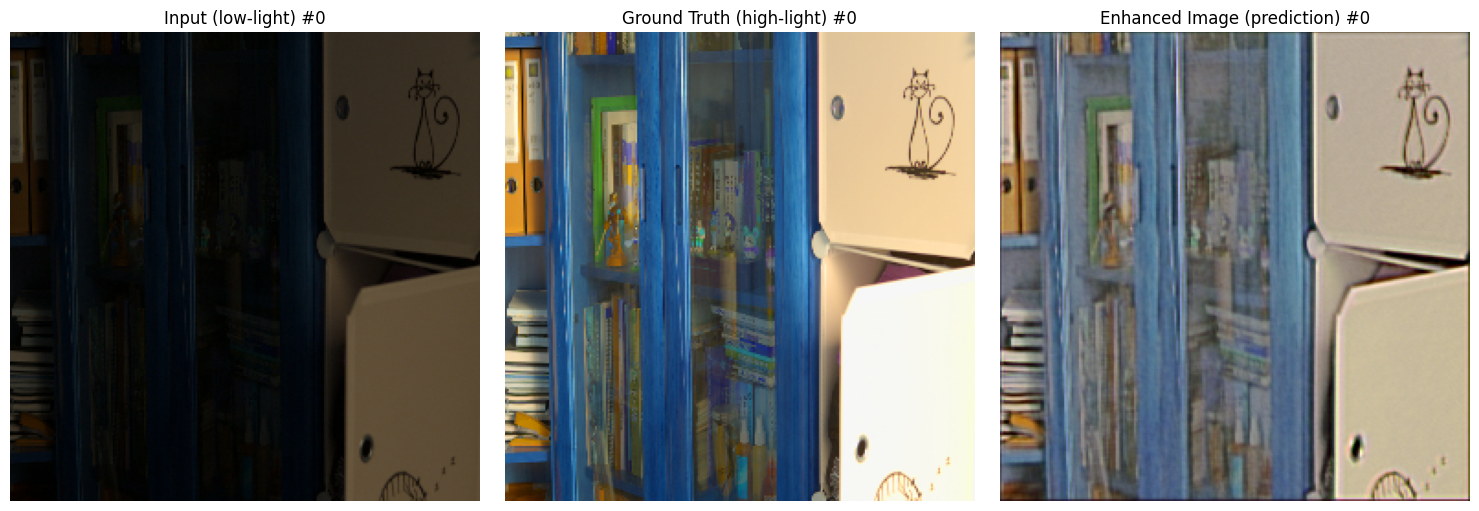

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0321211].


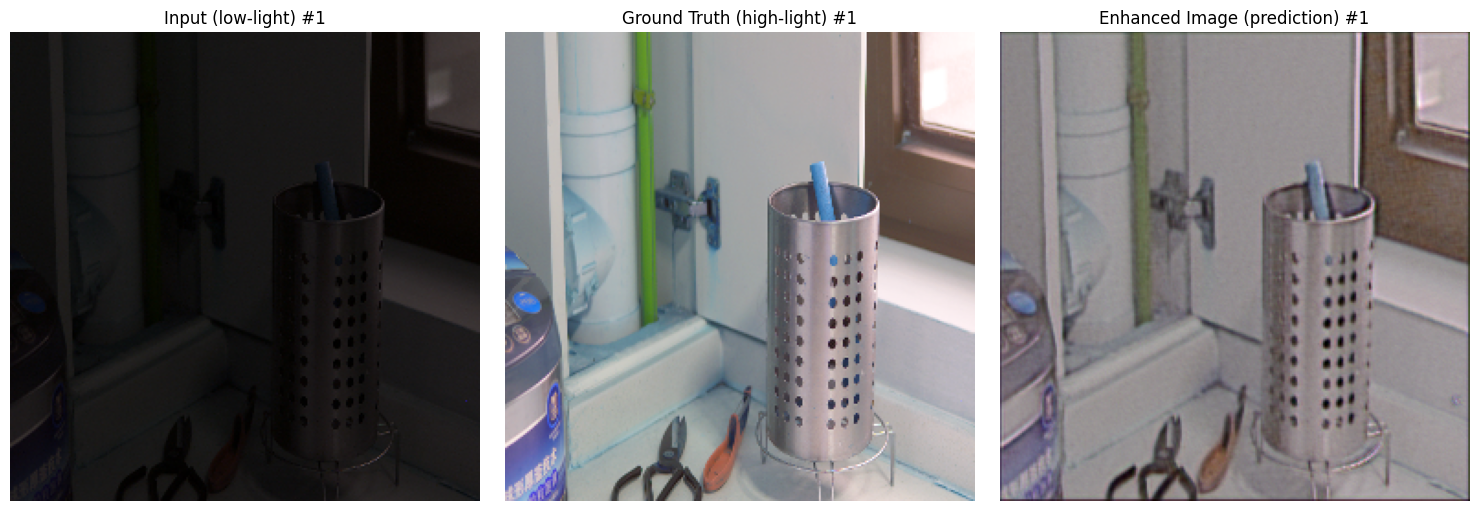

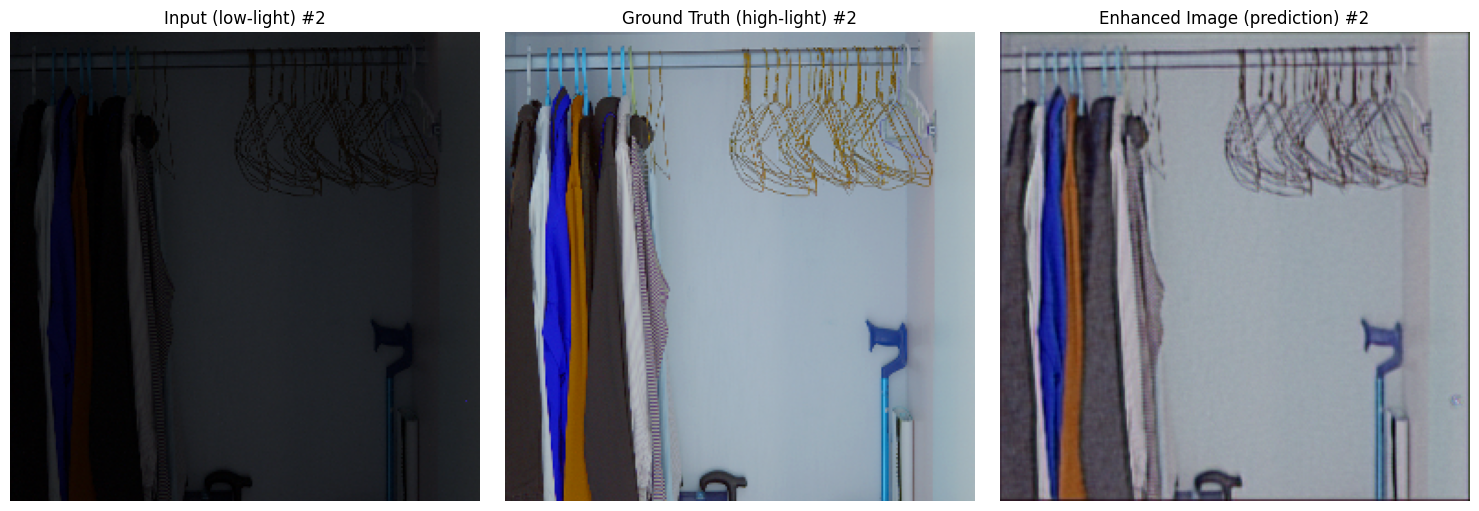

In [ ]:

def display_images(images, titles=None, cols=3, cmap=None):
    rows = len(images) // cols + (1 if len(images) % cols > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for i in range(min(3, test_mask_array.shape[0])):
    display_images([
        test_mask_array[i],      # Low-light input
        test_image_array[i],     # Ground truth high-light image
        predictions[i]           # Enhanced prediction
    ], 
    titles=[f'Input (low-light) #{i}', 
            f'Ground Truth (high-light) #{i}', 
            f'Enhanced Image (prediction) #{i}'])